In [ ]:
请参考https://mindspore.cn/mindquantum/docs/zh-CN/master/quantum_approximate_optimization_algorithm.html
完成如下图的MaxCut问题

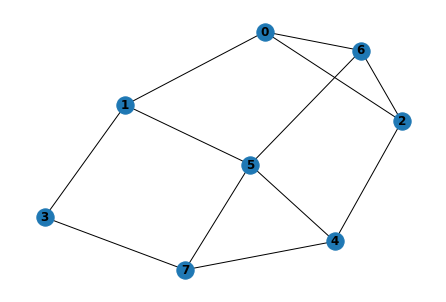

In [3]:
import networkx as nx
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
# nx.draw(g, with_labels=True, font_weight='bold')

def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路

import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti) 

for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  